In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torch.nn.init as init
import torch.nn.functional as F

# Check if GPU is available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

#### Data

In [2]:
# Load CFashionMNIST dataset
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

trainset = torchvision.datasets.FashionMNIST(root='data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=1024, num_workers=10, shuffle=True, drop_last=True)

testset = torchvision.datasets.FashionMNIST(root='data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=1024, num_workers=10, shuffle=False)

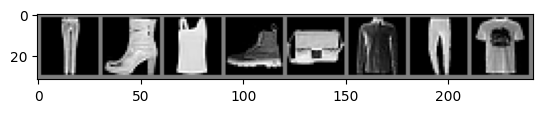

In [3]:
import matplotlib.pyplot as plt
import numpy as np

# Function to display the images
def imshow(img):
    img = img*0.5 + 0.5
    np_img = img.numpy()
    plt.imshow(np.transpose(np_img, (1, 2, 0)))
    plt.show()

for i, (images, labels) in enumerate(trainloader, 0):
    # Plot some images
    imshow(torchvision.utils.make_grid(images[:8]))  # Display 8 images from the batch
    break

#### Model

In [12]:
import torch
import torch.nn as nn
from torchsummary import summary

class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5, padding=2)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16*5*5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

model = LeNet()
model = model.to(device)

# Print model
summary(model, (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 28, 28]             156
         MaxPool2d-2            [-1, 6, 14, 14]               0
            Conv2d-3           [-1, 16, 10, 10]           2,416
         MaxPool2d-4             [-1, 16, 5, 5]               0
            Linear-5                  [-1, 120]          48,120
            Linear-6                   [-1, 84]          10,164
            Linear-7                   [-1, 10]             850
Total params: 61,706
Trainable params: 61,706
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.06
Params size (MB): 0.24
Estimated Total Size (MB): 0.30
----------------------------------------------------------------


#### Loss, Optimizer, and Evaluation Function

In [13]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

In [14]:
# Function to compute loss and accuracy for test set
def evaluate(model, testloader, criterion):
    model.eval()
    test_loss = 0.0
    running_correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in testloader:
            # Move inputs and labels to the device
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            running_correct += (predicted == labels).sum().item()

    accuracy = 100 * running_correct / total
    test_loss = test_loss / len(testloader)
    return test_loss, accuracy

#### Train

In [15]:
# some parameter
train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []
max_epoch = 150

In [16]:
# train
for epoch in range(max_epoch):
    model.train()
    running_loss = 0.0
    running_correct = 0   # to track number of correct predictions
    total = 0             # to track total number of samples

    for i, (inputs, labels) in enumerate(trainloader, 0):
        # Move inputs and labels to the device
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        running_loss += loss.item()

        # Determine class predictions and track accuracy
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        running_correct += (predicted == labels).sum().item()

        # Backward pass and optimization
        loss.backward()
        optimizer.step()        

    epoch_accuracy = 100 * running_correct / total
    epoch_loss = running_loss / (i + 1)
    
    test_loss, test_accuracy = evaluate(model, testloader, criterion)
    print(f"Epoch [{epoch + 1}/{max_epoch}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%, Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")
    
    # save for plot
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_accuracy)
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)

Epoch [1/150], Loss: 2.2491, Accuracy: 20.72%, Test Loss: 2.1304, Test Accuracy: 33.45%
Epoch [2/150], Loss: 1.7864, Accuracy: 47.64%, Test Loss: 1.3844, Test Accuracy: 60.60%
Epoch [3/150], Loss: 1.1168, Accuracy: 64.52%, Test Loss: 0.9350, Test Accuracy: 67.70%
Epoch [4/150], Loss: 0.8383, Accuracy: 70.26%, Test Loss: 0.7909, Test Accuracy: 70.94%
Epoch [5/150], Loss: 0.7403, Accuracy: 72.73%, Test Loss: 0.7287, Test Accuracy: 72.94%
Epoch [6/150], Loss: 0.6903, Accuracy: 74.23%, Test Loss: 0.6884, Test Accuracy: 74.60%
Epoch [7/150], Loss: 0.6563, Accuracy: 75.36%, Test Loss: 0.6592, Test Accuracy: 75.74%
Epoch [8/150], Loss: 0.6303, Accuracy: 76.33%, Test Loss: 0.6388, Test Accuracy: 75.65%
Epoch [9/150], Loss: 0.6088, Accuracy: 77.30%, Test Loss: 0.6218, Test Accuracy: 76.63%
Epoch [10/150], Loss: 0.5909, Accuracy: 78.05%, Test Loss: 0.6009, Test Accuracy: 77.47%
Epoch [11/150], Loss: 0.5746, Accuracy: 78.67%, Test Loss: 0.5906, Test Accuracy: 78.24%
Epoch [12/150], Loss: 0.5606, 

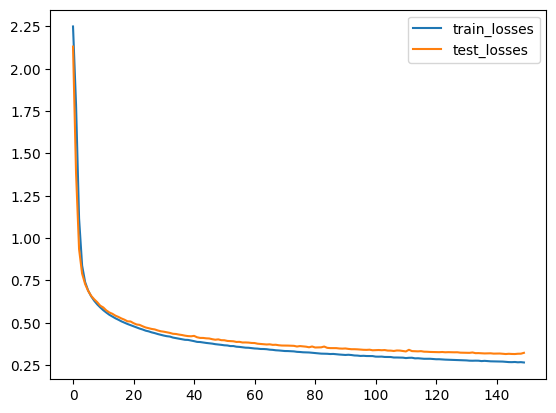

In [17]:
import matplotlib.pyplot as plt

plt.plot(train_losses, label='train_losses')
plt.plot(test_losses, label='test_losses')
plt.legend()

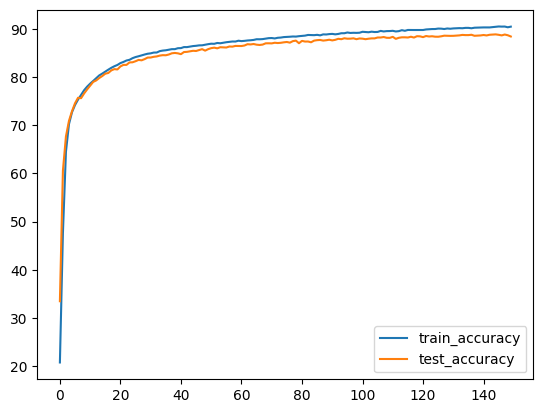

In [18]:
import matplotlib.pyplot as plt

plt.plot(train_accuracies, label='train_accuracy')
plt.plot(test_accuracies, label='test_accuracy')
plt.legend()

In [19]:
import matplotlib.pyplot as plt
%matplotlib qt

plt.plot(train_losses, label='train_losses')
plt.plot(test_losses, label='test_losses')
plt.legend()

In [20]:
import matplotlib.pyplot as plt
%matplotlib qt

plt.plot(train_accuracies, label='train_accuracy')
plt.plot(test_accuracies, label='test_accuracy')
plt.legend()